# Clasificación binaria: Diagnóstico de malignidad en tumores anexiales 

El presente trabajo corresponde a una de las actividades realizadas en la asignatura de **Machine Learning Aplicado**, impartida por el Dr. Julio Waissman Vilanova en el semestre 2022–1, que forma parte del conjunto de materias de la [Maestría en Ciencia de Datos de la Universidad de Sonora](https://mcd.unison.mx/).

## Introducción

El objetivo de este artículo es presentar algunas de las métricas y herramientas más utilizadas para la evaluación de los resultados otorgados por un algoritmo de clasificación binaria. Estos conceptos se abordarán desde un punto de vista práctico atacando una problemática del área de la medicina y se trabajará con datos reales utilizando Python.

### Problema a resolver: Malignidad en tumores anexiales

Los tumores anexiales son masas que se forman en los órganos y en los tejidos conjuntivos alrededor del útero, pueden encontrarse en ovarios, trompas de Falopio y alrededor de éstos; pueden aparecer cuando el ovario es funcionante o durante la menopausia. Los ginecólogos realizan hallazgos de este tipo de tumoraciones frecuentemente en la práctica diaria, sin embargo, es difícil hacer un pronóstico preoperatorio de benignidad o malignidad de una tumoración, por ello se deben buscar los medios de ofrecer a la paciente la mejor opción terapéutica con la menor morbilidad posible.

Existen diferentes índices de riesgo de malignidad de tumoraciones anexiales y utilizan las siguientes variables [[1]](https://www.ejgo.org/Synapse/Data/PDFData/1114JGO/jgo-22-177.pdf):
* Estado menopáusico de la paciente: premenopáusica, posmenopáusica (amenorrea mayor de un año)
* Resultados ultrasonográficos (multilocularidad, bilateralidad, componentes sólidos, ascitis y metástasis)
* Nivel en la concentración de CA-125
* Diámetro del tumor

![](imgs/5.png)

En este trabajo se pondrán a prueba diferentes clasificadores binarios cuyo objetivo será identificar si una tumoración es maligna o benigna, después se realizará una comparación de sus desempeños frente a un diagnóstico guiado únicamente por los índices de riesgo de malignidad.

## Análisis exploratorio

Se realizará un pequeño análisis exploratorio. Si bien es cierto que realizarlo no es parte del objetivo principal de esta publicación, el análisis exploratorio es una etapa vital del flujo de trabajo en problemas de ciencia de datos y nunca se debería de saltar ya que nos ayudará a entender la información con la que estamos trabajando e incluso nos marca el camino a seguir en las próximas etapas del proyecto.

### Descripción del conjunto de datos

Se trabajará con la información contenida en el archivo `IndicesMalignidadV2.csv`. El conjunto de datos fue recolectado por el Dr. Carlos Dávila Portillo y está conformado por observaciones reales de mujeres atendidas en el Hospital Integral de la Mujer del Estado de Sonora en el periodo comprendido de enero de 2011 a diciembre de 2016. Las pacientes con diagnóstico de tumoración anexial fueron intervenidas por laparotomía o laparoscopía y se realizó un estudio anatomopatológico de la pieza operatoria. Esta información es la que se incluye en el conjunto de datos además de otras características ultrasonográficas y atributos extraídos del expediente de las pacientes.

### Limpieza de datos

A continuación, se realizará una limpieza del conjunto de datos. Comenzamos importando las dependencias necesarias

In [1]:
# Para el manejo de los datos
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Para la graficación
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from roc_utils import compute_roc
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
sns.set_theme(style="darkgrid")

# Para realizar pruebas de hipótesis
from scipy import stats

# Para utilizar paquetes de R
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr

# Para utilizar los algoritmos de machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Para la generación de números aleatorios
import random
random.seed(1)

Unable to determine R library path: Command '('C:\\Users\\pedro\\anaconda3\\envs\\ckd\\lib\\R\\bin\\Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 1.


Ahora, un vistazo a los datos

In [2]:
df = pd.read_csv('data/IndicesMalignidadV2.csv')
df.head()

,id,edad,f_recoleccion,menopausica,paridad,ant_fam,grado,multilocularidad,bilateralidad,cmp_sol,ascitis,metastasis,vascularidad,diam_lesion,ca125,cirugia,f_cirugia,resultado,IRM1,IRM2,IRM3,IRM4
0,1,46,19/02/18,1,0,0,0,0,0,1,0,0,0,21.0,53,laparotomia,13/10/11,benigno,53,53,53,106
1,2,19,19/02/18,1,0,0,0,1,0,1,0,0,0,2.0,46,laparotomia,10/11/11,benigno,138,184,138,184
2,3,27,19/02/18,1,0,0,0,1,0,0,0,0,0,6.0,54,laparotomia,18/11/11,benigno,54,54,54,54
3,4,34,19/02/18,1,1,0,0,0,0,0,0,0,0,2.5,7,laparotomia,18/11/11,benigno,0,7,7,7
4,5,71,19/02/18,3,1,0,0,1,0,1,0,0,0,9.0,209,laparotomia,21/10/11,maligno,1881,3344,1881,6688


Podemos eliminar las columnas `id`, `f_recoleccion`, `cirugia` y `f_cirugia` ya que en este caso no brindan información relevante

In [3]:
df.drop(columns=['id', 'f_recoleccion', 'cirugia', 'f_cirugia'], inplace=True)

Revisamos que todas las variables estén representadas con el tipo de dato correcto

In [4]:
df.dtypes

edad                  int64
menopausica           int64
paridad               int64
ant_fam               int64
grado                 int64
multilocularidad      int64
bilateralidad         int64
cmp_sol               int64
ascitis               int64
metastasis            int64
vascularidad          int64
diam_lesion         float64
ca125                 int64
resultado            object
IRM1                  int64
IRM2                  int64
IRM3                  int64
IRM4                  int64
dtype: object

### Análisis de los datos

Comenzaremos analizando el comportamiento de la variable `edad`

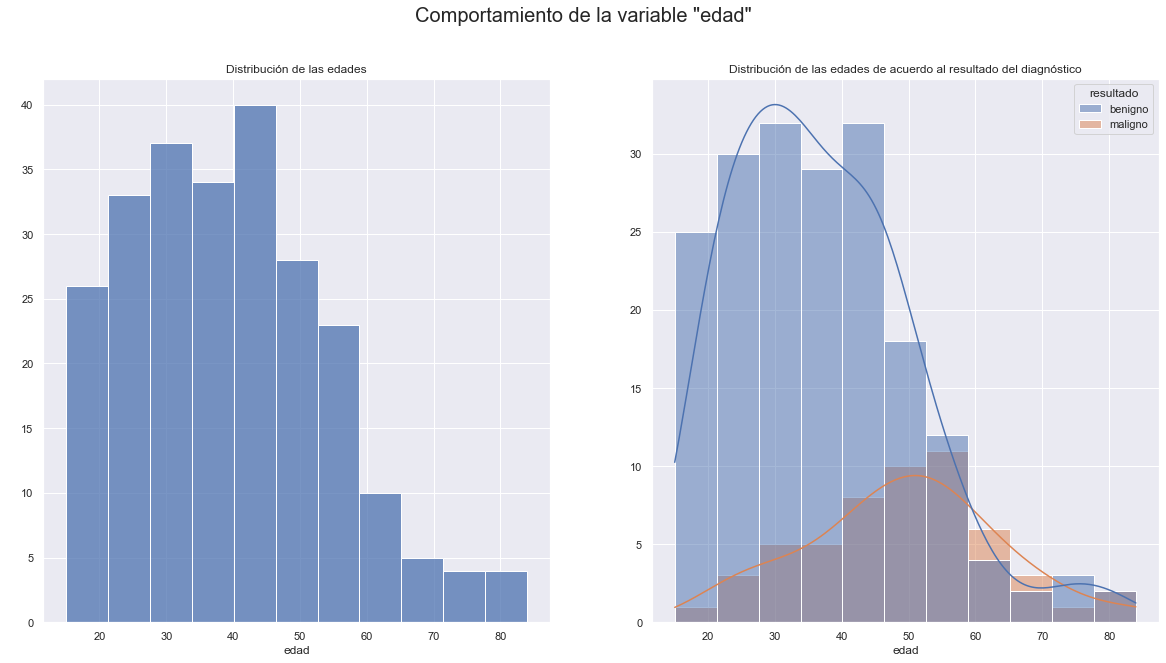

In [5]:
fig, axs = plt.subplots(1,2, figsize=(20,10))

fig.suptitle('Comportamiento de la variable "edad"', fontsize=20)

axs[0].set_title('Distribución de las edades')
axs[0].set_ylabel(' ')
sns.histplot(data=df, x="edad", ax=axs[0])

axs[1].set_title('Distribución de las edades de acuerdo al resultado del diagnóstico')
axs[1].set_ylabel(' ')
sns.histplot(data=df, x="edad", hue='resultado', kde=True, ax=axs[1])

plt.show()

Podemos observar que la gran mayoría de las pacientes son mujeres adultas de menos de 60 años; además, se nota cómo los resultados de malignidad postiva son más comunes en la adultez intermedia (50-60 años) y a partir de ahí tienden a decrementar, esto podría deberse a que existen relativamente pocas observaciones en adultos mayores.

Ahora, revisemos cómo se distribuye el resultado de los diagnósticos de acuerdo al diámetro de las lesiones

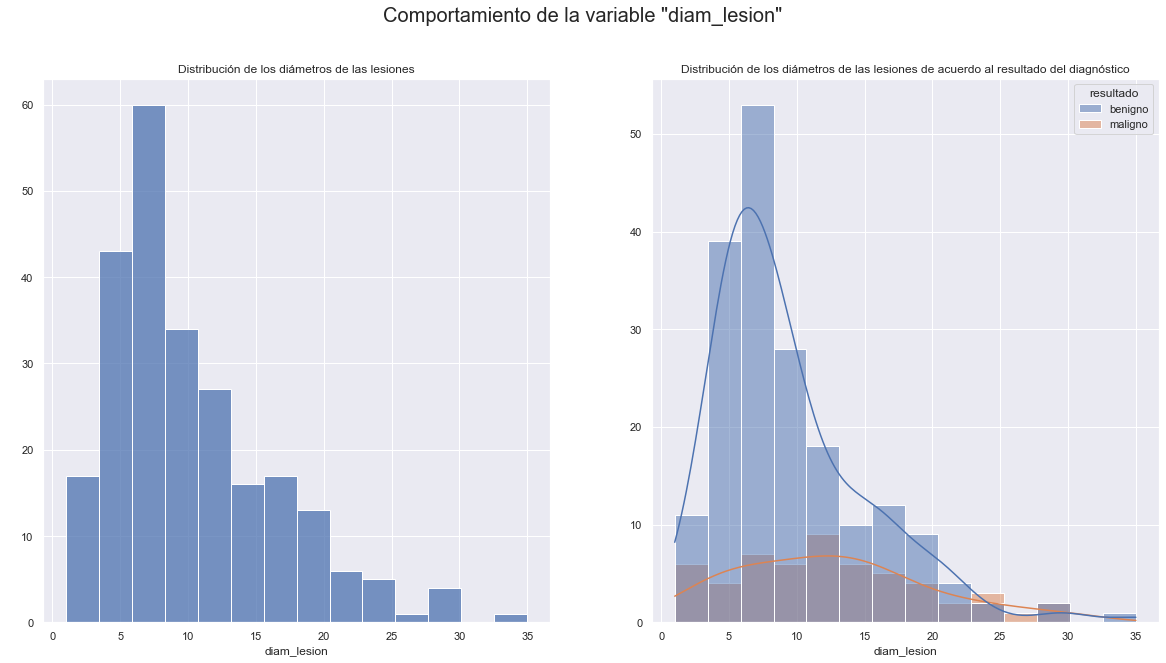

In [6]:
fig, axs = plt.subplots(1,2, figsize=(20,10))

fig.suptitle('Comportamiento de la variable "diam_lesion"', fontsize=20)

axs[0].set_title('Distribución de los diámetros de las lesiones')
axs[0].set_ylabel(' ')
sns.histplot(data=df, x="diam_lesion", ax=axs[0])

axs[1].set_title('Distribución de los diámetros de las lesiones de acuerdo al resultado del diagnóstico')
axs[1].set_ylabel(' ')
sns.histplot(data=df, x="diam_lesion", hue='resultado', kde=True, ax=axs[1])

plt.show()

A simple vista parece que el diámetro de la lesión no influye tanto en el resultado del diagnóstico; la gran mayoría de las observaciones son diámetros pequeños pero al parecer los resultados malignos se distribuyen sin ningún patrón significativo por todo el rango de valores, a excepción de un ligero pico entre el 10 y el 15.

In [7]:
print('Media y mediana de la variable "diam_lesion" agrupada por resultado')
df.groupby('resultado').diam_lesion.agg(['mean', 'median'])

Media y mediana de la variable "diam_lesion" agrupada por resultado


,mean,median
resultado,,
benigno,9.461376,8.0
maligno,12.629091,12.0


Observamos que, mientras los promedios y la mediana son prácticamente iguales dentro de un mismo grupo, sí son diferentes entre los resultados benignos y malignos.

Ahora, analicemos la variable `ca125`

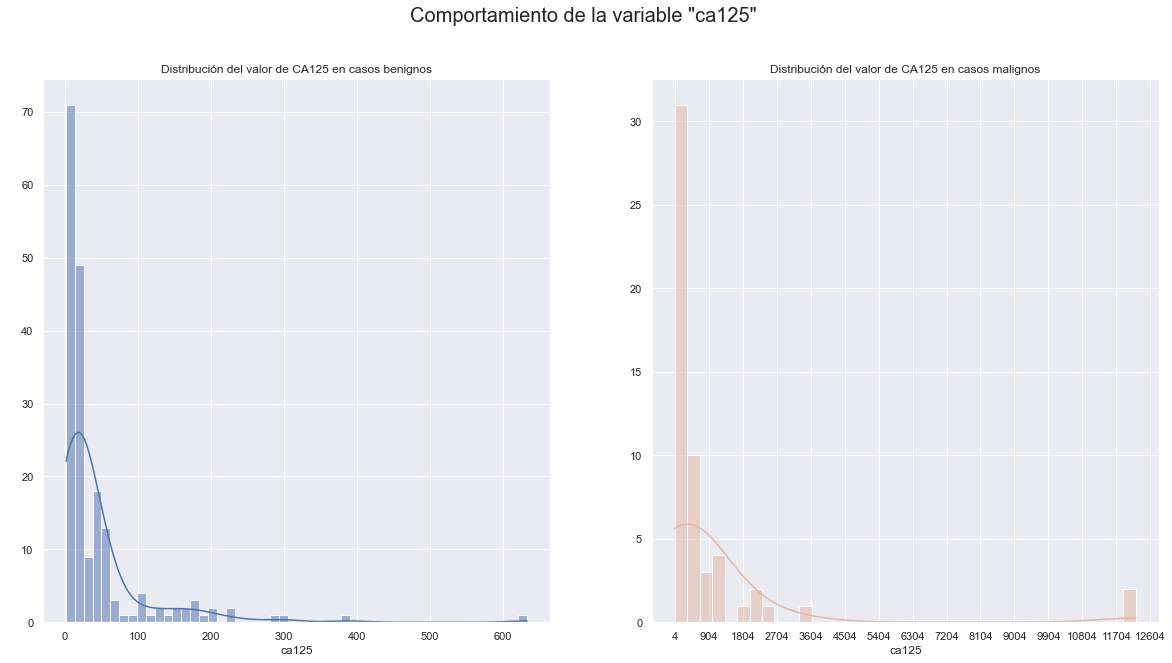

In [8]:
fig, axs = plt.subplots(1,2, figsize=(20,10))

fig.suptitle('Comportamiento de la variable "ca125"', fontsize=20)

axs[0].set_title('Distribución del valor de CA125 en casos benignos')
axs[0].set_ylabel(' ')
sns.histplot(data=df[df.resultado=='benigno'], x="ca125", kde=True, ax=axs[0])

axs[1].set_title('Distribución del valor de CA125 en casos malignos')
axs[1].set_ylabel(' ')
sns.histplot(data=df[df.resultado=='maligno'], x="ca125", kde=True, color='#e3b6a1',ax=axs[1])
axs[1].xaxis.set_ticks(np.arange(min(df[df.resultado=='maligno'].ca125), max(df[df.resultado=='maligno'].ca125)+900, 900.0))

plt.show()

A simple vista podemos notar que los valores para esta variable son considerablemente más altos en los casos malignos. Grafiquemos su logaritmo natural para obtener una mejor visualización

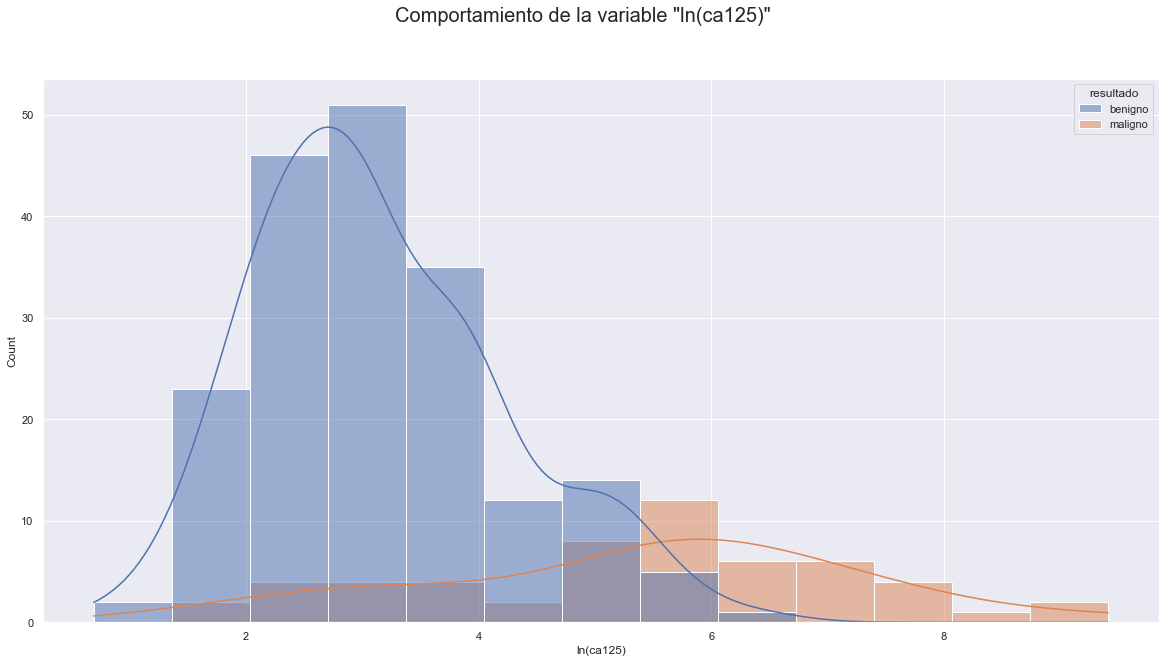

In [9]:
fig, ax = plt.subplots(figsize=(20,10))
datos = pd.DataFrame({'ln(ca125)':np.log(df.ca125), 'resultado':df.resultado})
fig.suptitle('Comportamiento de la variable "ln(ca125)"', fontsize=20)
sns.histplot(data=datos, x="ln(ca125)", hue='resultado', kde=True, ax=ax)


plt.show()

Revisando el logaritmo natural notamos un desfase en las distribuciones para cada tipo de resultado. Para corroborar este hecho de manera estadística vamos a ejecutar una prueba no paramétrica de Kruskal-Wallis [[2]](https://data.library.virginia.edu/getting-started-with-the-kruskal-wallis-test/#:~:text=Summary,-Kruskal%2DWallis%20tests&text=Kruskal%2DWallis%20can%20only%20tell%20us%20if%20the%20groups%20originate,originate%20from%20a%20different%20distribution.).

El contraste de hipótesis será el siguiente

$H_0 = \text{La distribución de los valores de CA125 es igual en casos benignos y malignos}$

$H_1 = \text{La distribución de los valores de CA125 es diferente en casos benignos y malignos}$

La prueba se realizará con un nivel de significancia $\alpha=0.05$

In [10]:
stats.kruskal(df[df.resultado=='benigno'].ca125, df[df.resultado=='maligno'].ca125)

KruskalResult(statistic=58.73816742886223, pvalue=1.8011346708428213e-14)

La prueba ha resultado significativa, por lo tanto, podemos concluir que la muestra ofrece evidencia estadística suficiente para sospechar que los valores del CA125 entre el grupo de pacientes con diagnóstico de malignidad positivo y negativo provienen de distribuciones diferentes.

A continuación, revisaremos cómo se distribuyen los cuatro índices de riesgo de malignidad de acuerdo al resultado de los diagnósticos

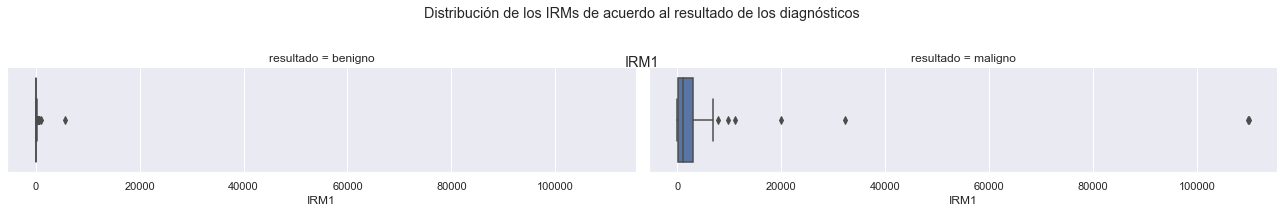

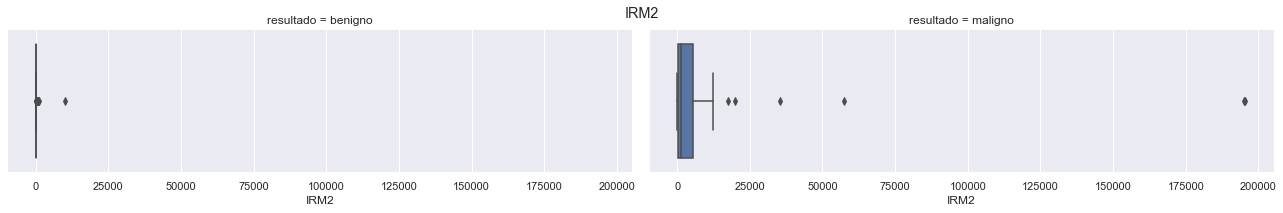

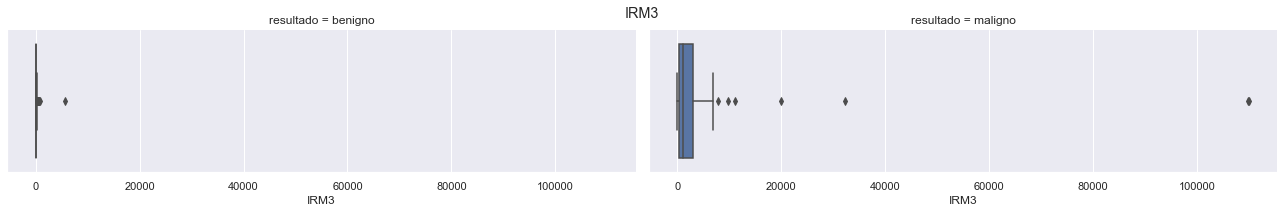

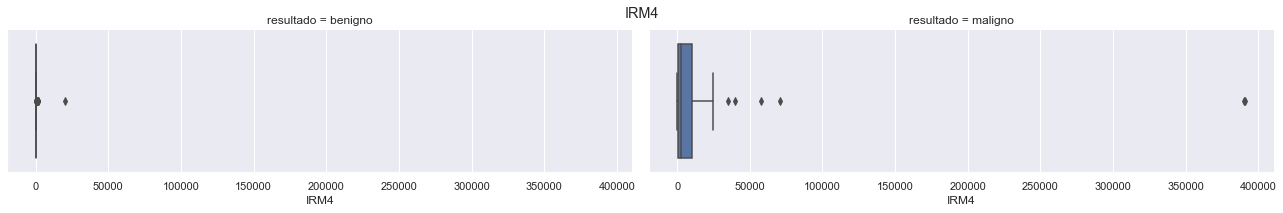

In [11]:
irms = list(df.columns[-4:-1]) + [df.columns[-1]]

for irm in irms:
    catplot = sns.catplot(x=irm, col="resultado", data=df, kind='box',height=3, aspect=3)
    if irm == 'IRM1':
        catplot.fig.subplots_adjust(top=.7)
        catplot.fig.suptitle(f'Distribución de los IRMs de acuerdo al resultado de los diagnósticos\n\n\n{irm}')
    else:
        catplot.fig.suptitle(irm)

    
plt.show()

Podemos notar que todos los valores de los IRMs para casos benignos se concentran muy cerca del cero, mientras que las distribuciones para casos malignos tienen un rango de valores considerablemente mayor.

Ahora, analicemos la relación que existe entre el resultado del diagnóstico y las variables categóricas

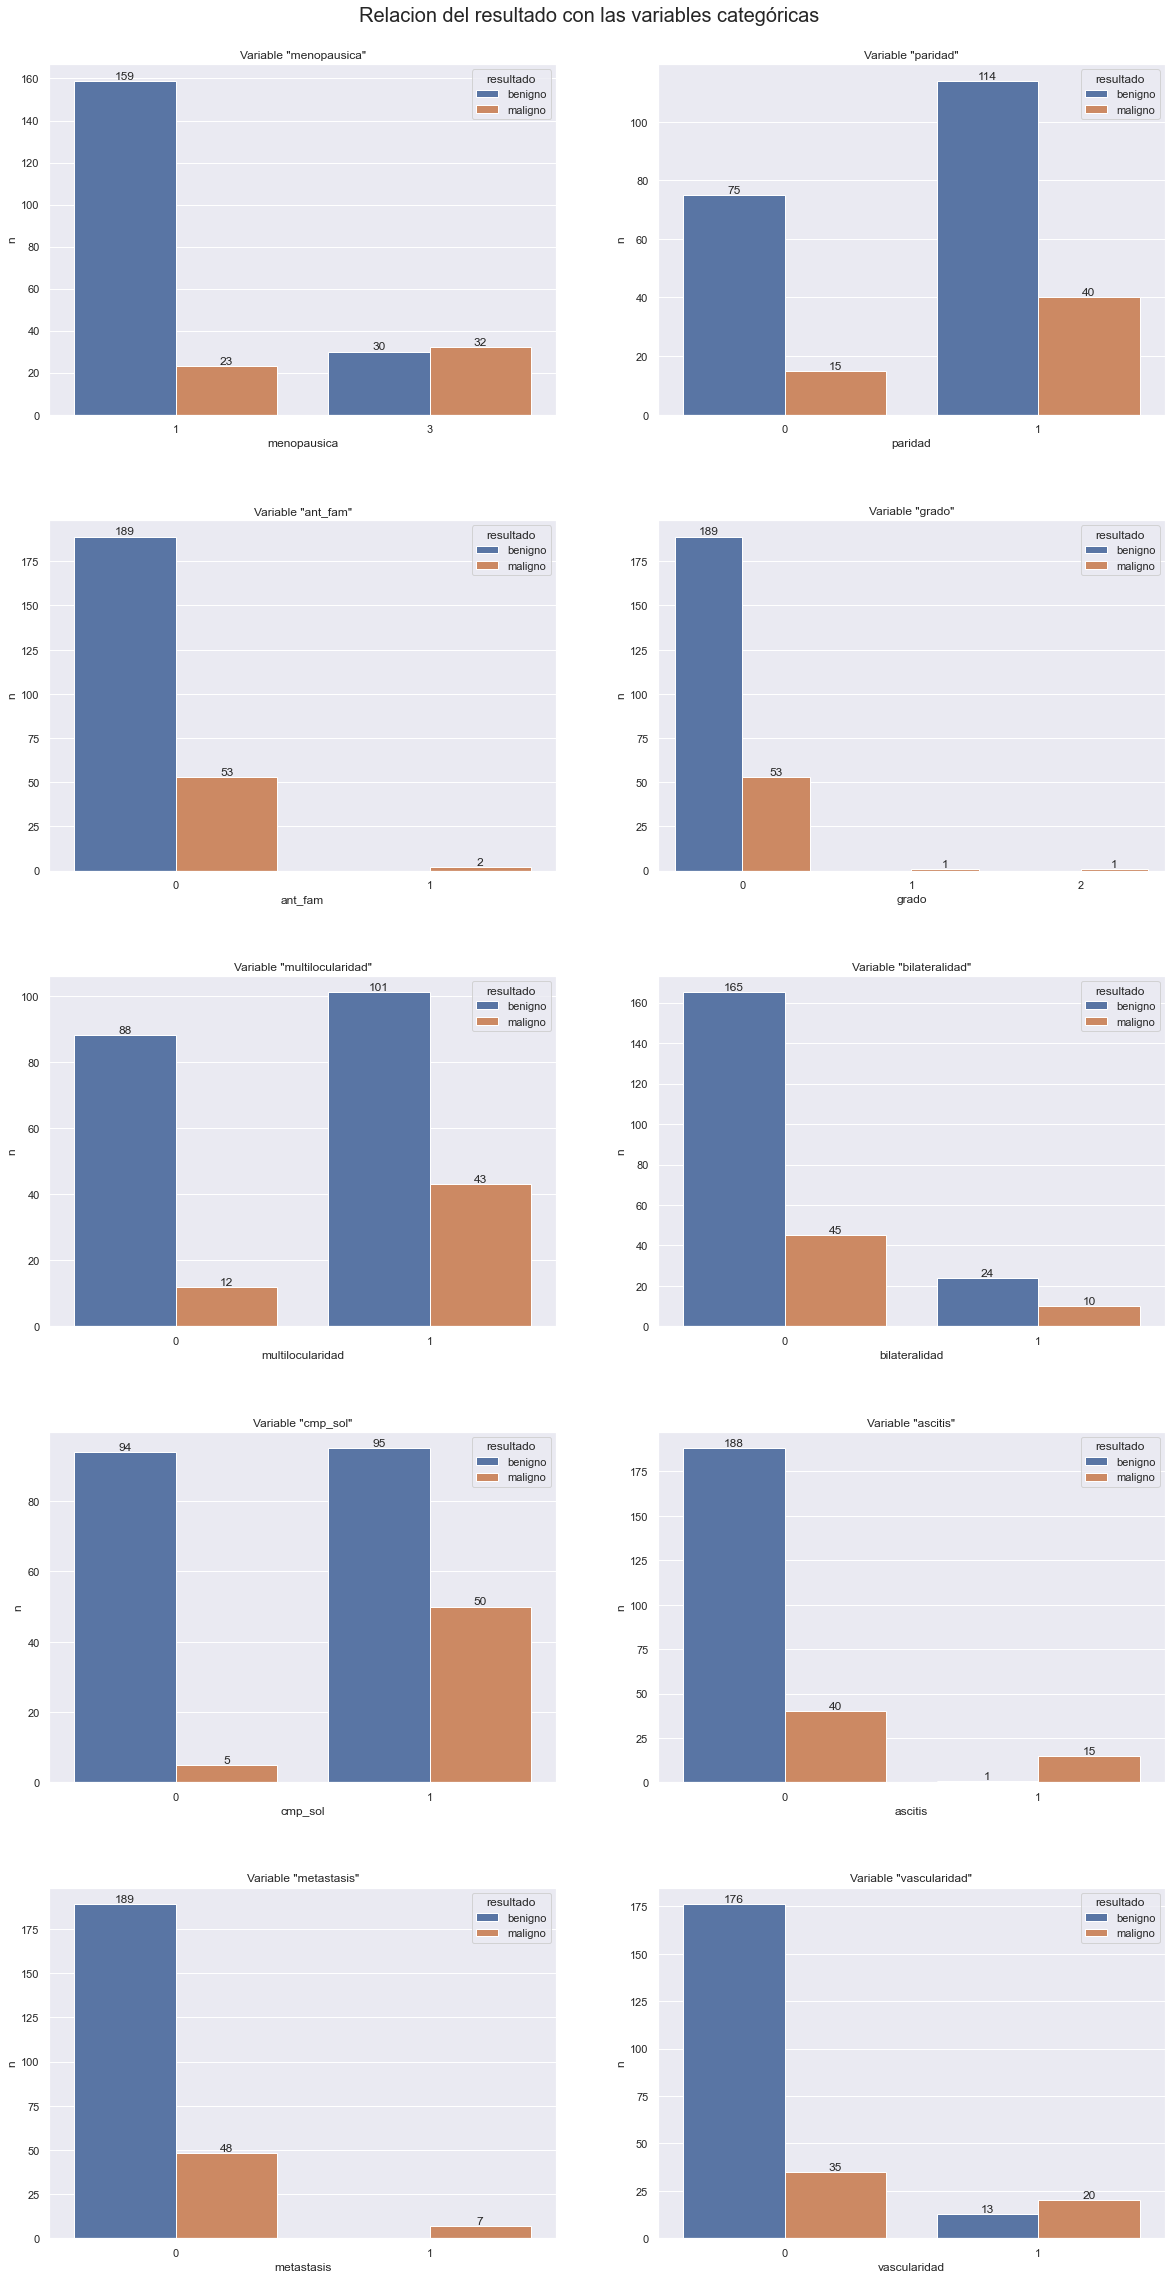

In [12]:
fig, axs = plt.subplots(5,2,figsize=(20,40))
axs = axs.ravel()

fig.suptitle('Relacion del resultado con las variables categóricas', fontsize=20, y=.9)
plt.subplots_adjust(hspace=.3)

cat_vars = df.columns[1:11]
for c, ax in zip(cat_vars, axs.ravel()):
    ax.set_title(f'Variable "{c}"')
    sns.countplot(data=df, x=c, hue="resultado", ax=ax)
    for i in ax.containers:
        ax.bar_label(i,)
    ax.set_ylabel('n')


    
plt.show()

En estas gráficas podemos observar algunos patrones importantes. Por ejemplo, se nota cómo el número de resultados malignos es muy bajo en comparación a los resultados benignos en pacientes premenopáusicas; sin embargo, en mujeres postmenopáusicas los números se mantienen prácticamente iguales. En el caso de la variable `ant_fam` podemos observar que existen solamente dos pacientes con antecedentes y que han resultado con un diagnóstico de malignidad positiva; por otro lado, muchas mujeres sin antecedentes familiares tienen el mismo diagnóstico. A simple vista no podemos emitir un veredicto acerca de si las variables categóricas tienen una relación importante con el resultado de los diagnósticos, así que habrá que recurrir al uso de una prueba de hipótesis, en este caso se realizarán pruebas exactas de Fischer [[3]](https://www.sciencedirect.com/topics/medicine-and-dentistry/fisher-exact-test).

Esta prueba no paramétrica se utiliza cuando se estudia la asociación o dependencia entre dos variables categóricas, es decir, cuando se necesita saber si las proporciones de una variable son diferentes en función del valor de la otra variable. Las hipótesis nula y alternativa son:

* $H_0 : \text{Las variables son independientes}$
* $H_1 : \text{Las variables son dependientes}$

Se ejecutará una prueba por cada variable categórica. En caso de que el resultado sea significativo tendremos evidencia para rechazar la hipótesis nula y podremos decir que el resultado del diagnóstico de malignidad depende de la variable en cuestión. Las pruebas se realizarán con un nivel de significancia $\alpha = 0.05$. 

Una vez que determinemos cuáles son las variables categóricas relacionadas con el diagnóstico de malignidad procederemos a medir su grado de asociación mediante la Gamma de Goodman y Kruskal. Este coeficiente va desde -1 a 1 y tiene una interpretación similar al coeficiente de correlación de Pearson

In [13]:
# Se importan los paquetes de R
rpy2.robjects.numpy2ri.activate()
stats = importr('stats')
desctools = importr('DescTools')
# Se crea una lista en donde se almacenará la información de
# cada prueba
datos = []

# Nivel de significancia
alpha = 0.05
for col in cat_vars:
    # Tabla de contingencia de la depresión vs la columna actual
    grouped = df.groupby([col, 'resultado']).size().unstack().fillna(0)
    # Se extrae el pvalor de la prueba de Fischer
    p = stats.fisher_test(grouped.values)[0][0]
    # Se interpreta el pvalor
    result = None
    goodmanKruskal = None
    if p < alpha:
        result = 'rechazar H0'
        # En caso de que el resultado sea significativo, se calcula la medida
        # de asociación
        n = np.sum(grouped.values)
        minDim = min(grouped.shape)-1
        goodmanKruskal = desctools.GoodmanKruskalGamma(grouped.values)[0]
    else:
        result = 'mantener H0'
    row = {}
    row['variable'] = col
    row['pvalor'] = p
    row['resultado'] = result
    row['GoodmanKruskal'] = goodmanKruskal
    datos.append(row)
# Se crea un dataframe con los resultados
resultados = pd.DataFrame(datos)
resultados.sort_values(by='GoodmanKruskal', ascending=False)

,variable,pvalor,resultado,GoodmanKruskal
8,metastasis,2.166493e-05,rechazar H0,1.000000
7,ascitis,4.992827e-10,rechazar H0,0.972028
6,cmp_sol,1.626254e-08,rechazar H0,0.816425
9,vascularidad,3.270415e-07,rechazar H0,0.771069
0,menopausica,2.067210e-09,rechazar H0,0.761163
4,multilocularidad,1.012332e-03,rechazar H0,0.514812
1,paridad,1.126370e-01,mantener H0,NaN
2,ant_fam,5.009107e-02,mantener H0,NaN
3,grado,5.009107e-02,mantener H0,NaN
5,bilateralidad,3.752097e-01,mantener H0,NaN


Los resultados en esta población resultan significativos para las variables `metastasis`, `ascitis`, `cmp_sol` (componentes sólidas), `vascularidad`, `menopausica` y `multilocularidad`. El grado de asociación es mayor que .80 en las tres primeras variables, entonces, dicha tercia de variables podrían ser las más explicativas al momento de realizar la clasificación.

## Clasificación binaria y herramientas para la evaluación de resultados

Una vez explorados los datos comenzaremos a resolver el problema. Primero hay que entender algunas definiciones.

### Conceptos básicos

Los algoritmos de clasificación son aquellos que tienen como objetivo predecir la clase a la que un ejemplo pertenece. Como su nombre lo indica, la clasificación binaria consiste en categorizar las observaciones únicamente utilizando dos clases. Existe una vasta cantidad de situaciones que pueden modelarse como un problema de clasificación binaria; por ejemplo, predecir si un componente electrónico es defectuoso, si un tweet es positivo o negativo, si un email es spam, o si un paciente sufre de cierta enfermedad. En esta ocasión el problema se relaciona con este último ejemplo.

La predicción de un modelo de clasificación binaria puede resultar únicamente de dos formas: predicción correcta o predicción incorrecta. Existen dos tipos de predicciones incorrectas, los **falsos positivos** y **falsos negativos**; análogamente, existen dos tipos de predicciones correctas, los **verdaderos positivos** y **verdaderos negativos**. En la medicina, para saber si los diagnósticos de cierta prueba son correctos o incorrectos, se recurre al **estándar de oro**, el cual es el estado verdadero del paciente y que es determinado por un comité de expertos basándose en los resultados del seguimiento del paciente o bien, de un método invasivo o pruebas especializadas.


* **Verdadero positivo**: Cuando se arroja una predicción positiva y el sujeto tiene un resultado postivo bajo el estándar de oro
* **Verdadero negativo**: Cuando se arroja una predicción negativa y el sujeto tiene un resultado negativo bajo el estándar de oro
* **Falso positivo**: Cuando se arroja una predicción positiva y el estándar de oro indica un resultado negativo
* **Falso negativo**: Cuando se arroja una predicción negativa y el estándar de oro indica un resultado positivo

![https://folk.ntnu.no/stoylen/strainrate/distribution.png](imgs/6.png)

Un falso positivo podría resultar en que un paciente sea sometido a un tratamiento muy agresivo sin estar enfermo, lo cual afectaría su economía pues generalmente el costo de los tratamientos para enfermedades graves es extremadamente elevado e incluso podría llegar a comprometer su vida; por otro lado, también perjudicaría a los centros de salud pues estarían desperdiciando recursos valiosos en un paciente que no lo necesita. Los falsos negativos también son un problema serio, por ejemplo, si el diagnóstico de una enfermedad contagiosa resulta negativo para una persona infectada, podría no solo comprometer su vida, sino también la de todas las personas que la rodean. Si seguimos analizando podremos encontrar muchísimos más ejemplos en donde un error de predicción podría resultar catastrófico, especialmente en aportaciones a la medicina; por ello, es de vital importancia minimizar los falsos positivos y los falsos negativos.

Es importante aclarar que los términos *verdadero positivo* ($\text{VP}$), *verdadero negativo* ($\text{VN}$), *falso positivo* ($\text{FP}$) y *falso negativo* ($\text{FN}$) pueden generalizarse a cualquier problema de clasificación binaria; en muchos casos, sean cuales sean las clases, se opta por renombrar a una de ellas como la **clase positiva** ($1$) y a la otra como **clase negativa** ($0$).

La técnica por excelencia para dar un primer vistazo a estas cuatro mediciones es la **matriz de confusión**. En el caso de la clasificación binaria es una matriz de 2x2 en donde los renglones representan a las clases reales, mientras que las columnas representan a las clases predichas (o al revés), de tal forma que la diagonal principal representará los aciertos (VP y VN), mientras que la diagonal secundaria estará formada por los errores (FP y FN)

![https://miro.medium.com/max/838/1*IYfAEqJN6CDtBqS2WTN5Jg.png](imgs/7.png)

### Métricas de desempeño

Como ya hemos visto, en un problema de clasificación binaria todo gira entorno a los VP, VN, FP y FN. Lo ideal sería no equivocarse nunca, es decir, siempre cometer cero falsos negativos y cero falsos positivos; sin embargo, en la gran mayoría de problemas reales esto no es posible. Por ello resulta importante establecer con el cliente las metas y los indicadores de desempeño del proyecto ya que en algunas aplicaciones será preferible cometer falsos negativos que cometer falsos positivos, y en otras ocasiones sucederá lo contrario.

Retomemos el ejemplo de someter a un paciente a un tratamiento que no necesita pues resultó ser un falso positivo. Desde un punto de vista generoso y humanitario parece ser que esto es preferible a cometer un falso negativo, es decir, no someter al paciente al tratamiento que necesita debido a que está enfermo y su vida corre peligro; para muchas enfermedades peligrosas casi siempre se realiza más de una prueba con la finalidad de descartar o aceptar con total seguridad un diagnóstico positivo antes de comenzar con los tratamientos. Es verdad, el costo de las pruebas afectará la situación económica del paciente, sacrificará tiempo valioso en atenderse e incluso podría llegar a tener repercusiones psicológicas; sin embargo, tarde o temprano la enfermedad será descartada. Ahora, desde el punto de vista del negocio, ¿este hecho realmente le conviene al centro de salud? la respuesta más probable es que no. Como ya se mencionó con anterioridad, todas estas pruebas adicionales a las que se someterá el paciente representan un gasto no solo para él mismo, sino también para el hospital. En caso de tratarse de un centro de salud con pocos recursos, estos gastos "innecesarios" no serían deseables y probablemente preferirían cometer falsos negativos (no atender a un paciente cuando lo necesita) a cambio de cometer muy pocos falsos positivos (gastar recursos innecesarios), de esta forma estarían asegurando que casi todo diagnóstico positivo será correcto y, por lo tanto, la mayoría de las veces se gastarán los recursos exactos en las demás pruebas.

Ahora sabemos que los objetivos de una tarea de clasificación pueden llegar más allá del hecho de no equivocarse. Existen diferentes métricas para evaluar el desempeño de acuerdo al objetivo del negocio, las más habituales son: **Sensibilidad/recall/true positive rate**, **especificidad/true negative rate**, **precision**, **accuracy** y **F1 Score**. 

#### Sensibilidad/Recall/True Positive Rate

En el Machine learning suele llamarse *recall* y se refiere a la proporción de verdaderos positivos que fueron identificados correctamente. En el ámbito de la medicina es la proporción de aquellos que tienen la enfermedad y que han obtenido un diagnóstico positivo; es decir, es la probabilidad de que un individuo con la enfermedad resulte positivo. En este contexto se le conoce como *sensibilidad*.

$\text{Sensibilidad/Recall/True Positive Rate} = \frac{\text{VP}}{\text{VP+FN}}$

Esta métrica debe tomarse en cuenta si el objetivo es identificar con certeza a todos los verdaderos positivos.

#### Especificidad/True Negative Rate

Se refiere a la proporción de verdaderos negativos que fueron identificados correctamente. En el ámbito de la medicina es la proporción de aquellos sin la enfermedad y para quienes la prueba ha arrojado negativo; es decir, es la probabilidad de que un individuo sin la enfermedad resulte negativo en el test.

$\text{Especificidad/True Negative Rate} = \frac{\text{VN}}{\text{VN+FP}}$

Esta métrica es importante si el objetivo es identificar con certeza a todos los verdaderos negativos.

#### False Positive Rate

Es la proporción de verdaderos negativos que fueron clasificados erróneamente como elementos de la clase positiva.

$\text{False Positive Rate} = \frac{\text{FP}}{\text{FP+VN}}$

Esta métrica se debería tomar en cuenta si la penalización por cometer falsos positivos es muy alta.

#### False Negative Rate

Es la proporción de verdaderos positivos que fueron clasificados erróneamente como elementos de la clase negativa.

$\text{False Negative Rate} = \frac{\text{FN}}{\text{FN+VP}}$

Toma especial importancia en los casos donde la penalización por cometer falsos negativos es muy alta.

#### Precision

Es el porcentaje de aciertos dentro de todas las predicciones positivas.

$\text{Precision} = \frac{\text{VP}}{\text{VP+FP}}$

Un modelo poco preciso encontrará muchos positivos, pero gran parte de ellos serán incorrectos (muchos falsos positivos); en cambio, un modelo altamente preciso tal vez no encuentre todos los positivos, pero la gran mayoría de los que encuentre serán correctos. Esta métrica es importante si el objetivo es reducir el número de falsos positivos.

#### Accuracy

Esta métrica representa el porcentaje de aciertos total del clasificador

$\text{Accuracy} = \frac{\text{VP+VN}}{\text{VP+VN+FP+FN}}$

El accuracy es muy engañoso y no es tan relevante en escenarios donde los falsos negativos o falsos positivos tengan un costo elevado, o cuando las clases son imbalanceadas. Por ejemplo, puede ser que el True Negative Rate no sea aceptable y que al mismo tiempo el accuracy sea muy alto. Debe tomarse en cuenta si el único objetivo es no equivocarse, cuando todos los errores (FN y FP) tengan el mismo costo o cuando ambas clases tengan aproximadamente el mismo número de ejemplos.

#### F1 Score

Esta métrica representa a la media armónica entre **Precision** y **Recall**

$\text{F1-Score} = \frac{2 \cdot \text{Precision} \cdot \text{Recall}}{\text{Precision + Recall}}$


* Si el modelo tiene un F1-Score alto, entonces tiene buena Precision y buen Recall
* Si el modelo tiene un F1-Score bajo, entonces su Precision y Recall son bajos
* Si el modelo tiene un F1-Score medio, entonces su Precision es alta y su Recall bajo o viceversa.

### Curvas ROC

En la medicina, las curvas ROC (Receiver Operating Characteristics) son ampliamente utilizadas para medir la especificidad y sensibilidad de las pruebas diagnósticas. Esta herramienta es una representación gráfica que muestra la relación entre el **True positive rate** y el **False positive rate**. Por otro lado, en el ámbito del Machine learning, esta herramienta es una de las más utilizadas al momento de establecer el punto de corte óptimo para un clasificador binario.

![https://lh5.googleusercontent.com/V4wPMFisHpulNmykBD5NMHgqCTKB_Cvu5kZe6igAQXp-yxfqAc-yZbYad42K05su5xDCud6FzOkQTTekQkTZi7vGS5XPV82KceRPQFXvIGakT0RW82sdyGgaU3AQFq5hJ9rGA6Y](imgs/8.png)

Un clasificador perfecto no comete errores, es decir, su True positive rate es 1 y su False Positive Rate es 0. Sabiendo esto, la curva ROC nos puede informar a simple vista qué tan "perfecto" es nuestro clasificador. Si obtenemos una curva ROC semejante a la recta $Y=x$ deberíamos preocuparnos, pues el algoritmo estaría arrojando predicciones prácticamente aleatorias; entre más cerca de la esquina superior izquierda se localice la curva, mejor. 

Es importante señalar que en la literatura ajena al Machine learning es muy común que las curvas ROC grafiquen la relación entre **sensibilidad** y **1-especificidad**, pero es exactamente lo mismo. De entrada, sabemos que la sensibilidad es igual al True Positive Rate; de la misma forma, 1-especificidad es igual al False Positive Rate, aquí la demostración:

$\text{Specificity} = \frac{\text{VN}}{\text{VN+FP}}$

$\text{1 - Specificity} = 1 - \frac{\text{VN}}{\text{VN+FP}}$

$\text{1 - Specificity} = \frac{\text{VN+FP-VN}}{\text{VN+FP}}$

$\text{1 - Specificity} = \frac{\text{FP}}{\text{VN+FP}} = \text{False Positive Rate}$

![https://www.researchgate.net/publication/359170272/figure/fig1/AS:1132498750840833@1647020151204/Three-examples-of-ROC-curve-are-illustrated-A-AUC1-A-perfect-classifier-B.png](imgs/9.png)

La manera de resumir toda la información de este gráfico es mediante el área bajo la curva (AUC); entre más se acerque a 1, mejor rendimiento tendrá el clasificador. Ahora, es bien sabido que obtener un clasificador perfecto es muy, pero muy difícil. Por ejemplo, existen técnicas de ingeniería de características y ajuste de hiperparámetros para mejorar el rendimiento de un algoritmo de clasificación, aún aplicándolas es probable que la perfección no se alcance y para muchas tareas complejas ni siquiera se pretenderá hacerlo y bastará con cumplir algún criterio mínimo impuesto por el cliente, pero siempre debemos buscar el mejor resultado posible. En una curva ROC el mejor punto de corte $c$ se puede determinar utilizando diferentes criterios, uno de los más utilizados es el **Índice de Youden** que se calcula como:

$J = max_c \{\text{sensitivity(c)} + \text{specificity(c)} - 1\}$

o bien

$J = max_c \{\text{True Positive Rate(c) - False Positive Rate(c)}\}$

En este punto ya entendemos las curvas ROC, ahora hay que aprender a construirlas. Recordemos que uno de los objetivos principales de esta herramienta es obtener un punto de corte óptimo para un clasificador binario; en el caso de la medicina, el mejor punto de corte representará la sensitividad y la especificidad de la prueba diagnóstica. 

Para seguir los estándares del Machine learning llamaremos 1 a la clase positiva y 0 a la clase negativa. En el estudio que estamos abordando, la clase positiva 1 representa a los casos donde el resultado es maligno; la clase negativa 0 representa a los casos donde el resultado es benigno.

Una vez renombradas las clases, el primer paso es definir los puntos de corte que se pretenden medir, luego se procede de acuerdo al siguiente pseudocódigo:

```
# Se itera cada punto de corte
Para cada punto de corte c:
    # Todas las métricas de la matriz de confusión para el punto de corte actual
    # comienzan en cero
    num_VP = 0
    num_VN = 0
    num_FP = 0
    num_FN = 0
    
    # Se itera sobre cada observación
    Para cada observación x:
        # Si la observación es mayor o igual al punto de corte,
        # se considera un positivo, en caso contrario se considera
        # un negativo
        si x.valor >= c entonces:
            resultado_impuesto = 1
        en otro caso:
            resultado_impuesto = 0
        
        # Se determina si el resultado impuesto es VP, VN, FP ó FN
        si x.resultado_real == 1 Y resultado_impuesto == 1 entonces:
            num_VP += 1
        si x.resultado_real == 1 Y resultado_impuesto == 0 entonces:
            num_FN += 1
        si x.resultado_real == 0 Y resultado_impuesto == 1 entonces:
            num_FP += 1
        si x.resultado_real == 0 Y resultado_impuesto == 0 entonces:
            num_VN += 1
    
    # Una vez revisadas todas las observaciones se obtiene el TPR y el FPR y
    # posteriormente se grafican estos valores para el punto de corte actual
    true_positive_rate = num_VP / (num_VP + num_FN)
    false_positive_rate = num_FP / (num_FP + num_VN)
    graficar_punto_xy(false_positive_rate, true_positive_rate)
```

En Python existe una excelente librería especializada en curvas ROC llamada [roc-utils](https://github.com/hirsch-lab/roc-utils) la cual se utilizará en este trabajo para facilitar algunos detalles de programación. Antes de probar algoritmos de Machine Learning analicemos las curvas ROC para los cuatro IRMS

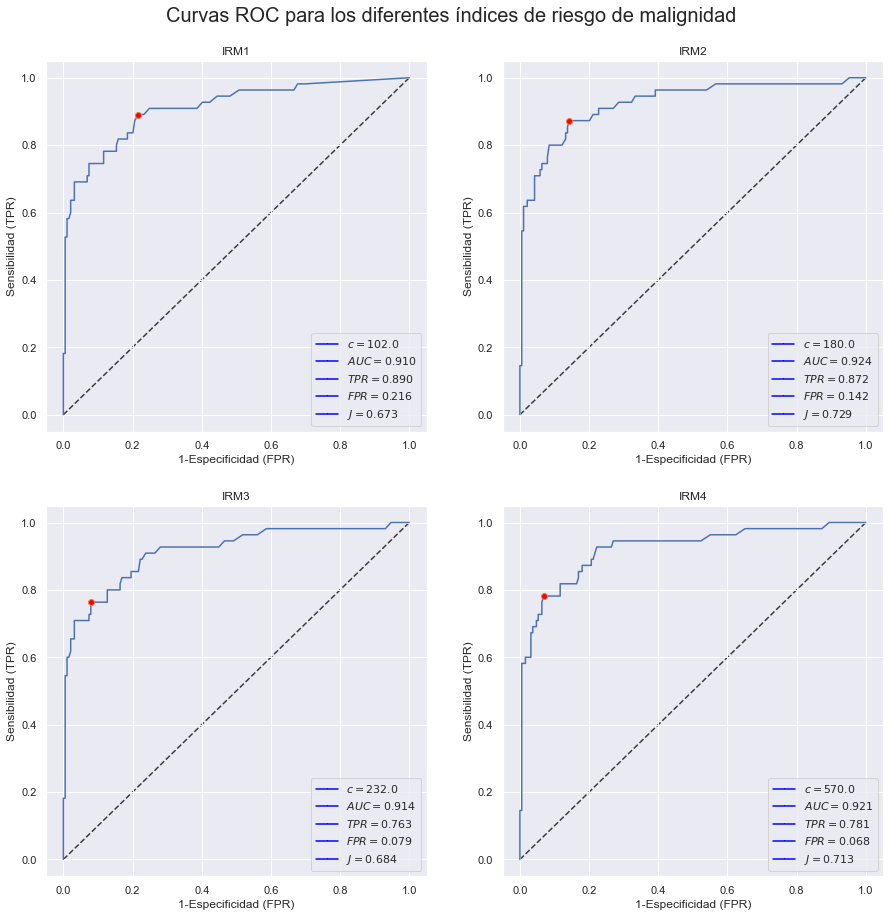

In [14]:
def graficarCurvaRoc(roc, titulo, ax):
    """
        Esta función grafica una curva ROC
        
        Argumentos
        ----------
        - roc <roc_utils._types.StructContainer>: Objeto que regresa la función
          "compute_roc" de la librería roc-utils.
        - titulo <str>: Título para la gráfica.
        - ax <matplotlib.axes>: Eje (axis) en donde se 
          graficará la curva.
          
        Regresa
        -------
        None
    """
    
    # Se escribe el título
    ax.set_title(titulo)
    # Se nombran a los ejes
    ax.set_xlabel('1-Especificidad (FPR)')
    ax.set_ylabel('Sensibilidad (TPR)')
    # Se grafica la curva
    ax.plot(roc.fpr, roc.tpr)
    # Se grafica la recta Y=x
    ax.plot([0,1], [0,1], '--', alpha=0.75, zorder=0, color='black')
    
    # Se toman las métricas del objeto roc
    punto = roc.opd['youden'].opp
    idx = roc.opd['youden'].ind
    mejor_tpr = str(roc.tpr[idx])[:5]
    mejor_fpr = str(roc.fpr[idx])[:5]
    mejor_thresh = str(roc.thr[idx])[:5]
    auc = str(roc.auc)[:5]
    j = str(roc.opd['youden'].opo)[:5]
    
    # Se grafica el punto del mejor índice de Youden
    ax.plot(punto[0], punto[1], marker="o", markerfacecolor="red")
    
    # Se escriben las métricas relevantes
    c_lgnd = mlines.Line2D([], [], color='blue', marker=',',
                          markersize=15, label=f"$c = {mejor_thresh}$")
    auc_lgnd = mlines.Line2D([], [], color='blue', marker=',',
                          markersize=15, label=f"$AUC = {auc}$")
    tpr_lgnd = mlines.Line2D([], [], color='blue', marker=',',
                          markersize=15, label=f"$TPR = {mejor_tpr}$")
    fpr_lgnd = mlines.Line2D([], [], color='blue', marker=',',
                          markersize=15, label=f"$FPR = {mejor_fpr}$")
    j_lgnd = mlines.Line2D([], [], color='blue', marker=',',
                          markersize=15, label=f"$J = {j}$")

    ax.legend(handles=[c_lgnd, auc_lgnd, tpr_lgnd, fpr_lgnd, j_lgnd])

    
# Se reemplaza el nombre de las clases por 0 y 1
df = df.replace({'resultado':{'benigno':0, 'maligno':1}})

fig, axs = plt.subplots(2,2,figsize=(15,15))
irms = list(df.columns[-4:-1]) + [df.columns[-1]]

fig.suptitle('Curvas ROC para los diferentes índices de riesgo de malignidad', fontsize=20, y=.93)
for irm, ax in zip(irms, axs.ravel()):
    roc = compute_roc(X=df[irm], y=df.resultado, pos_label=1, objective='youden')
    graficarCurvaRoc(roc, irm, ax)

Existe muy poca diferencia entre el desempeño general mostrado por los cuatro índices, esto lo podemos saber porque su AUC es casi el mismo. Para elegir un "mejor" IRM se necesitarían analizar los objetivos particulares ¿es preferible detectar a todos los pacientes enfermos o a todos los ?, ¿qué tipo de error tiene un mayor costo, los falsos positivos o los falsos negativos?

En este caso el IRM1 tiene la sensibilidad más alta de todos, es decir, es el que mejor desempeño tiene al momento de identificar a todos los verdaderos positivos, sin embargo, es el que más errores comete asociados con los falsos positivos ya que su FPR es el más alto; en este sentido podemos decir que el IRM1 es el índice más "cauteloso" pues sus diagnósticos positivos son muy reurrentes. En un caso extremo de "cautela" podríamos decirle a todos los pacientes que tienen cáncer, aquí también tendríamos una sensibilidad muy alta (perfecta) pero su porcentaje de falsos positivos sería del 100%. Para los hospitales que no quieren desperdiciar recursos en tratamientos innecesarios probablemente esta será su opción menos viable para realizar diagnósticos de malignidad en tumores anexiales. En contraste, observemos los resultados del IRM4. Su sensibilidad es aproximadamente un 10% más baja que la del IRM1, sin embargo su FPR es el mejor de los cuatro; este índice no es el mejor al momento de identificar a todos los verdaderos positivos, pero cuando arroja un diagnóstico positivo es más probable que sea correcto. Entonces, el IRM4 sería la mejor opción para el centro de salud con pocos recursos.

Para revisar las otras métricas debemos clasificar las observaciones utilizando los mejores puntos de corte; lo haremos sobre sus matrices de confusión

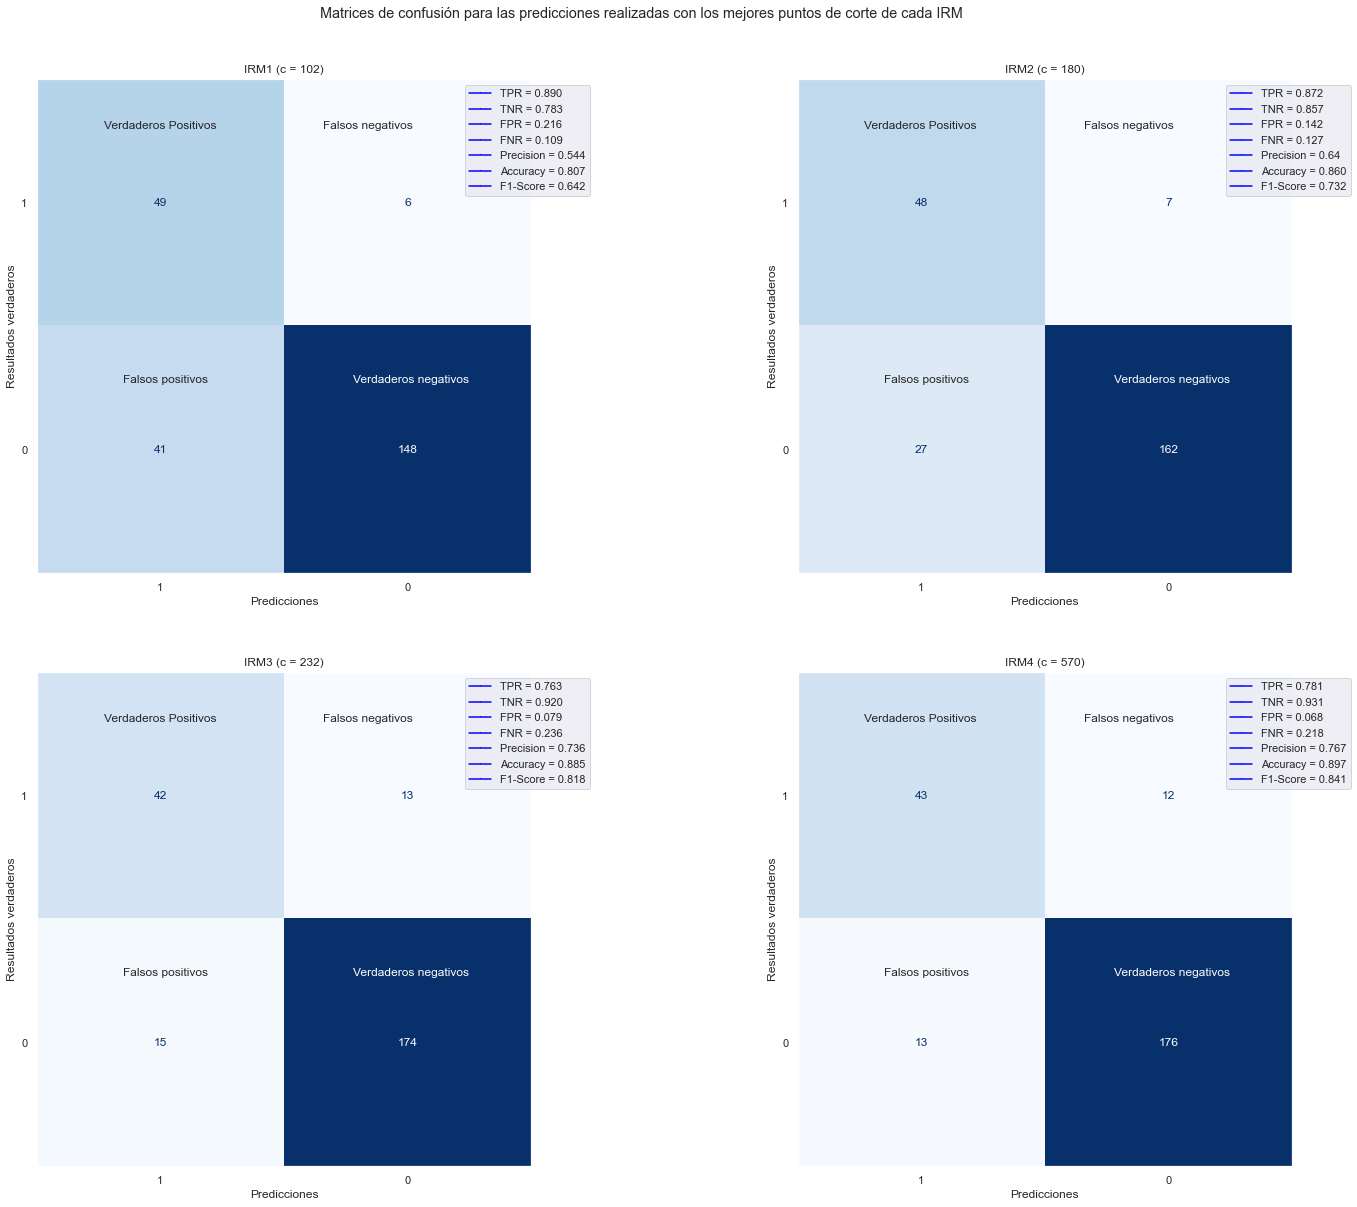

In [15]:
def graficarMatrizConfusion(resultados_verdaderos, predicciones, titulo, ax):
    """
        Esta función grafica una matriz de confusión
        
        Argumentos
        ----------
        - resultados_verdaderos <list>/<pandas.Series>/<numpy.array>: Lista de
                                resultados verdaderos.
        - predicciones <list>/<pandas.Series>/<numpy.array>: Lista de
                       predicciones.
        - titulo <str>: Título para la matriz de confusión.
        - ax <matplotlib.axes>: Eje (axis) en donde se graficará la matriz.
        
        Regresa
        -------
        - None

    """
    
    # Se calcula el número de VP, VN, FP y FN
    vp = np.where( (resultados_verdaderos == 1) & (predicciones == 1), 1, 0).sum()
    vn = np.where( (resultados_verdaderos == 0) & (predicciones == 0), 1, 0).sum()
    fp = np.where( (resultados_verdaderos == 0) & (predicciones == 1), 1, 0).sum()
    fn = np.where( (resultados_verdaderos == 1) & (predicciones == 0), 1, 0).sum()
    
    # Se grafica la matriz
    ax.grid(False)
    ax.set_title(titulo)
    ConfusionMatrixDisplay.from_predictions(resultados_verdaderos, predicciones, labels=[1,0], cmap='Blues', colorbar=False, ax=ax)
    ax.set_ylabel('Resultados verdaderos')
    ax.set_xlabel('Predicciones')
    
    # Se escriben las métricas relevantes
    precision = vp/(vp+fp)
    recall = vn/(vn+fp)
    
    tpr_lgnd = mlines.Line2D([], [], color='blue', marker=',',
                          markersize=15, label=f"TPR = {str(vp/(vp+fn))[:5]}")
    tnr_lgnd = mlines.Line2D([], [], color='blue', marker=',',
                          markersize=15, label=f"TNR = {str(recall)[:5]}")
    fpr_lgnd = mlines.Line2D([], [], color='blue', marker=',',
                          markersize=15, label=f"FPR = {str(fp/(fp+vn))[:5]}")
    fnr_lgnd = mlines.Line2D([], [], color='blue', marker=',',
                          markersize=15, label=f"FNR = {str(fn/(fn+vp))[:5]}")
    precision_lgnd = mlines.Line2D([], [], color='blue', marker=',',
                          markersize=15, label=f"Precision = {str(precision)[:5]}")
    acc_lgnd = mlines.Line2D([], [], color='blue', marker=',',
                          markersize=15, label=f"Accuracy = {str((vp+vn)/(vp+vn+fp+fn))[:5]}")
    f1_lgnd = mlines.Line2D([], [], color='blue', marker=',',
                          markersize=15, label=f"F1-Score = {str((2*precision*recall)/(precision+recall))[:5]}")
    
    ax.legend(handles=[tpr_lgnd, tnr_lgnd, fpr_lgnd, fnr_lgnd, precision_lgnd, acc_lgnd, f1_lgnd], bbox_to_anchor=(1.13, 1.))
    
    ax.text(-.23,-.3,'Verdaderos Positivos')
    ax.text(.66,-.3,'Falsos negativos')
    ax.text(.78,.73,'Verdaderos negativos', color='white')
    ax.text(-.15,.73,'Falsos positivos')


# Mejores puntos de corte para cada IRM
puntos_corte = {'IRM1':102, 'IRM2':180, 'IRM3':232, 'IRM4': 570}

fig, axs = plt.subplots(2, 2, figsize=(25,20))

plt.suptitle('Matrices de confusión para las predicciones realizadas con los mejores puntos de corte de cada IRM', y=.93)

# Se grafica la matriz de confusión para cada punto de corte
for irm, ax in zip(puntos_corte.keys(), axs.ravel()):
    predicciones = np.where(df[irm] > puntos_corte[irm], 1, 0)
    graficarMatrizConfusion(df.resultado, predicciones, f'{irm} (c = {puntos_corte[irm]})', ax)
    
plt.show()

Analizando las matrices de confusión también podemos extraer información relevante que nos ayude a tomar una decisión acerca de cuál índice es el mejor dependiendo de nuestros objetivos. Por ejemplo, con las curvas ROC llegamos a la conclusión de que, si la meta es no desperdiciar recursos en tratamientos innecesarios (reducir falsos positivos), entonces el mejor índice es el IRM4 porque su FPR es el más bajo. Ahora, si la prioridad del centro de salud es no cometer falsos negativos, entonces el IRM4 se ve superado por el IRM1 porque este último tiene el FNR más bajo. En el caso de que ambos tipos de error tengan la misma importancia, el IRM4 gana otra vez porque su accuracy es el más alto. Resumiento un poco:

* Si únicamente nos interesa el desempeño al momento de identificar a los casos positivos, entonces el mejor índice es el IRM1 porque su TPR es el más alto
* Si únicamente nos interesa el desempeño al momento de identificar a los casos negativos, entonces el mejor índice es el IRM4 porque su especificidad ($1-\text{FPR}$) y TNR son los más altos
* Si nos interesa minimizar la ocurrencia de falsos positivos, también el mejor índice es el IRM4 porque su FPR es el más bajo
* Si nos interesa minimizar la ocurrencia de falsos negativos, el mejor índice es el IRM1 porque su FNR es el más bajo
* Si la meta es obtener diagnósticos precisos es decir, que cuando las predicciones sean positivas exista una buena probabilidad de que se traten de verdaderos positivos, entonces el mejor índice es el IRM4 ya que su precisión es la más alta.
* Si nos interesa obtener un modelo con un buen balance entre la detección de verdaderos positivos y verdaderos negativos, entonces el mejor índice es el IRM4 pues su F1-Score es el más alto.
* Si únicamente nos interesa no equivocarnos, o si ambos tipos de error tienen el mismo costo, entonces el mejor índice es el IRM4 porque su accuracy es la más alta.

En conclusión, parece ser que en términos generales el IRM4 es el mejor índice.

### Algoritmos de machine learning

A continuación revisaremos tres diferentes algoritmos de Machine learning para clasificación binaria: **Máquinas de vectores de soporte (SVM)**, **Regresión logística** y **Bosques aleatorios (Random forest)**. La teoría detrás de cada algoritmo así como las técnicas de preparación datos e ingeniería de características están fuera del alcance de este trabajo y nos concentraremos exclusivamente en la evaluación de los resultados.

En la preparación de los datos se seguirán los siguientes pasos: Se eliminará la columna `grado` porque consta únicamente de los valores **0**, **1**, **2** y para los valores 1 y 2 existe solamente un caso. También se ejecutarán reemplazos en la columna `menopausica`, cambiaremos el valor de premenopáusica de 1 a 0 y el valor de postmenopáusica de 3 a 1. Luego separaremos los datos en conjuntos de entrenamiento (80%) y prueba (20%) de una forma estratificada, es decir, la proporción original de diagnósticos benignos y malignos se mantendrá en ambos conjuntos. Finalmente se estandarizarán las variables numéricas (`edad`, `diam_lesion`, `ca125`, `IRM1`, `IRM2`, `IRM3`, `IRM4`). El entrenamiento de los modelos se realizará ejecutando un 10-Fold Cross Validation para cada uno así como también una sencilla optimización de hiperparámetros con gridsearch, la métrica de desempeño será el Índice de Youden.

**Preparación de los datos**

In [16]:
# Removemos la columna 'grado' 
df = df.drop(columns=['grado'])

# Reemplazamos los valores de la columna 'menopausica'
df = df.replace({'menopausica':{1:0, 3:1}})
# Separamos los datos en matriz de diseño y vector de resultados
cols_idx = [i for i in range(len(df.columns))]
y = df.iloc[:, 12]
cols_idx.remove(12)
X = df.iloc[:, cols_idx]

# Separamos los datos en conjunto de entrenamiento y de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, stratify=y, random_state=1)

# Estandarizamos las variables numéricas
num_cols=['edad', 'diam_lesion', 'ca125', 'IRM1', 'IRM2', 'IRM3', 'IRM4']

sc = StandardScaler()
X_train[num_cols] = sc.fit_transform(X_train[num_cols])
X_test[num_cols] = sc.transform(X_test[num_cols])

**Entrenamiento de los modelos**

In [17]:
def entrenarModelo(X, y, modelo, grid, scorer, n_folds):
    """
        Esta función entrena un modelo de Sci-kit learn
        
        Parámetros
        ----------
        - X <pandas.core.frame.DataFrame> ó <numpy.ndarray>: Matriz de diseño.
        - y <pandas.core.series.Series> ó <numpy.ndarray>: Vector de salidas.
        - modelo: Modelo de Sci-kit learn que será entrenado.
        - grid <dict>: Diccionario con todos los valores e hiperparámetros a
                       optimizar.
        - scorer <sklearn.metrics._scorer._PredictScorer>: Función para evaluar
                 el desempeño del modelo.
        - n_folds <int>: Número de Folds para el cross validation.
        
        Regresa
        -------
        
        - search <sklearn.model_selection._search.GridSearchCV>: Objeto que 
                 contiene los resultados del cross validation con grid search.
        
        
    """
    search = GridSearchCV(
        modelo, grid, cv=n_folds, scoring=scorer, return_train_score=True
    )
    
    search = search.fit(X, y)
    
    return search

def obtenerIndiceYouden(resultados_verdaderos, predicciones):
    """
        Esta función calcula el índice de Youden.
        
        Argumentos
        ----------
        - resultados_verdaderos <pandas.Series>/<numpy.array>: Lista de
                                resultados verdaderos.
        - predicciones <pandas.Series>/<numpy.array>: Lista de
                       predicciones.
        
        Regresa
        -------
        - tpr-fpr <float>: Índice de Youden.
    """
    # Se calculan los VP, VN, FP y FN
    vp = np.where( (resultados_verdaderos == 1) & (predicciones == 1), 1, 0).sum()
    vn = np.where( (resultados_verdaderos == 0) & (predicciones == 0), 1, 0).sum()
    fp = np.where( (resultados_verdaderos == 0) & (predicciones == 1), 1, 0).sum()
    fn = np.where( (resultados_verdaderos == 1) & (predicciones == 0), 1, 0).sum()
    
    # Se calcula el TPR y el FNR
    tpr = vp/(vp+fn)
    fpr = fp/(fp+vn)
    
    # Se regresa el índice de Youden
    return tpr - fpr

# Se crea un Scorer de Sci-kit learn para utilizarlo como medida de desempeño
# al entrenar
youden_score = make_scorer(obtenerIndiceYouden)

# SVM
grid_svm = {
    'C':[random.uniform(0, 2) for _ in range(10)],
    'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'decision_function_shape':['ovo', 'ovr']
}
svm = entrenarModelo(X_train, y_train, SVC(random_state=1), grid_svm, youden_score, 10)
print('SVM entrenado')

# Regresión logística
grid_lr = {
    'C':[random.uniform(0, 3) for _ in range(100)],
}
lr = entrenarModelo(X_train, y_train, LogisticRegression(random_state=1), grid_lr, youden_score, 10)
print('LR entrenado')

# Random Forest
grid_rf = {
    'n_estimators':[i for i in range(100, 600, 100)],
    'criterion': ['gini', 'entropy'],
    
}
rf = entrenarModelo(X_train, y_train, RandomForestClassifier(random_state=1), grid_rf, youden_score, 10)
print('RF entrenado')

SVM entrenado
LR entrenado
RF entrenado


Una vez entrenados los modelos revisaremos las curvas de validación para darnos una idea acerca de la capacidad de generalización de cada algoritmo, es decir, para detectar casos de overfitting o underfitting

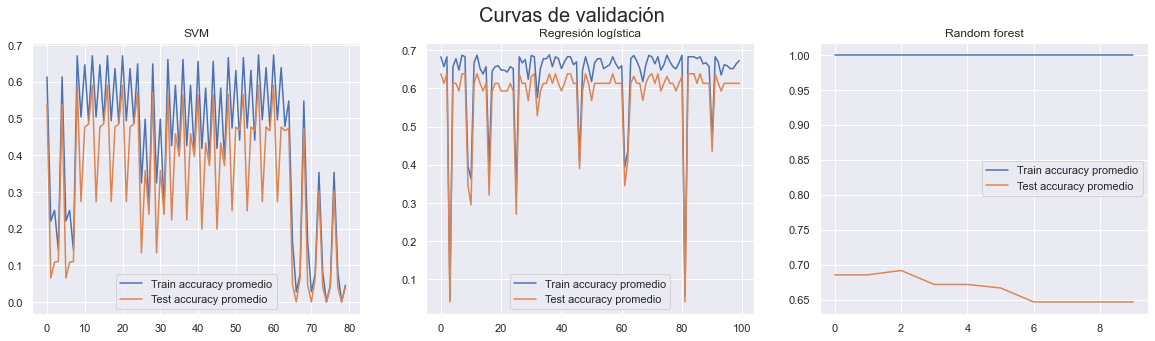

In [18]:
clasificadores = {'SVM':svm, 'Regresión logística':lr, 'Random forest':rf}

fig, axs = plt.subplots(1,3,figsize=(20,5))
plt.suptitle('Curvas de validación', fontsize=20)

for clf, ax in zip(clasificadores.keys(), axs):
    test_scores = clasificadores[clf].cv_results_['mean_test_score']
    train_scores = clasificadores[clf].cv_results_['mean_train_score']
    
    ax.set_title(clf)
    
    ax.plot(train_scores, label='Train accuracy promedio')
    ax.plot(test_scores, label='Test accuracy promedio')
    
    ax.legend()

Vemos que para el SVM y la regresión logística el accuracy promedio de los 10 folds en cada experimento se parcen mucho, aunque en la regresión logística las dos curvas se encuentran ligeramente más cerca entre ellas. En el caso de Random Forest el sobreaprendizaje es evidente.

**Matrices de confusión de los algoritmos de clasificación**

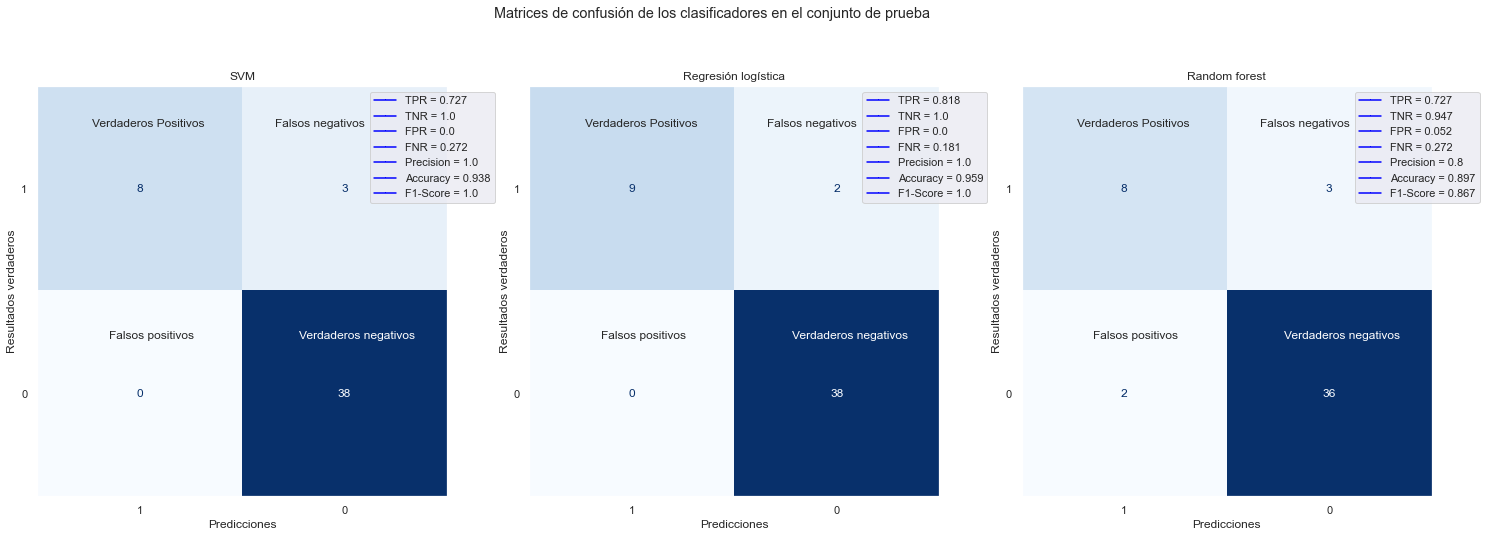

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(25,20))

plt.suptitle('Matrices de confusión de los clasificadores en el conjunto de prueba', y=.7)

for clf, ax in zip(clasificadores.keys(), axs.ravel()):
    predicciones = clasificadores[clf].predict(X_test)
    graficarMatrizConfusion(y_test, predicciones, clf, ax)

De los tres clasificadores, los mejores son el SVM y la regresión logística. Podemos observar que su desempeño al momento de encontrar a todos los verdaderos positivos se ve superado por los TPR de los IRMs; sin embargo, tanto el SVM como la regresión logística cuentan con una precision perfecta ya que su número de falsos positivos es cero. Esto quiere decir que, aunque no logran capturar a todos los verdaderos positivos, cuando detectan un tumor maligno es 100% probable que la predicción sea correcta. También sus TNR y FPR son perfectos lo que a su vez representa una especificidad perfecta, es decir, la probabilidad de que un paciente sano obtenga una predicción negativa es del 100%. El único detalle son sus falsos negativos, ambos algoritmos otorgan resultados negativos a algunos pacientes enfermos.

Como experimento final se van a comparar los desempeños de los IRMs y el mejor clasificador (regresión logística) sobre el conjunto de datos de prueba.

C:\Users\pedro\AppData\Local\Temp\ipykernel_26108\535233489.py:34: RuntimeWarning: invalid value encountered in long_scalars
  precision = vp/(vp+fp)
C:\Users\pedro\AppData\Local\Temp\ipykernel_26108\535233489.py:34: RuntimeWarning: invalid value encountered in long_scalars
  precision = vp/(vp+fp)
C:\Users\pedro\AppData\Local\Temp\ipykernel_26108\535233489.py:34: RuntimeWarning: invalid value encountered in long_scalars
  precision = vp/(vp+fp)
C:\Users\pedro\AppData\Local\Temp\ipykernel_26108\535233489.py:34: RuntimeWarning: invalid value encountered in long_scalars
  precision = vp/(vp+fp)


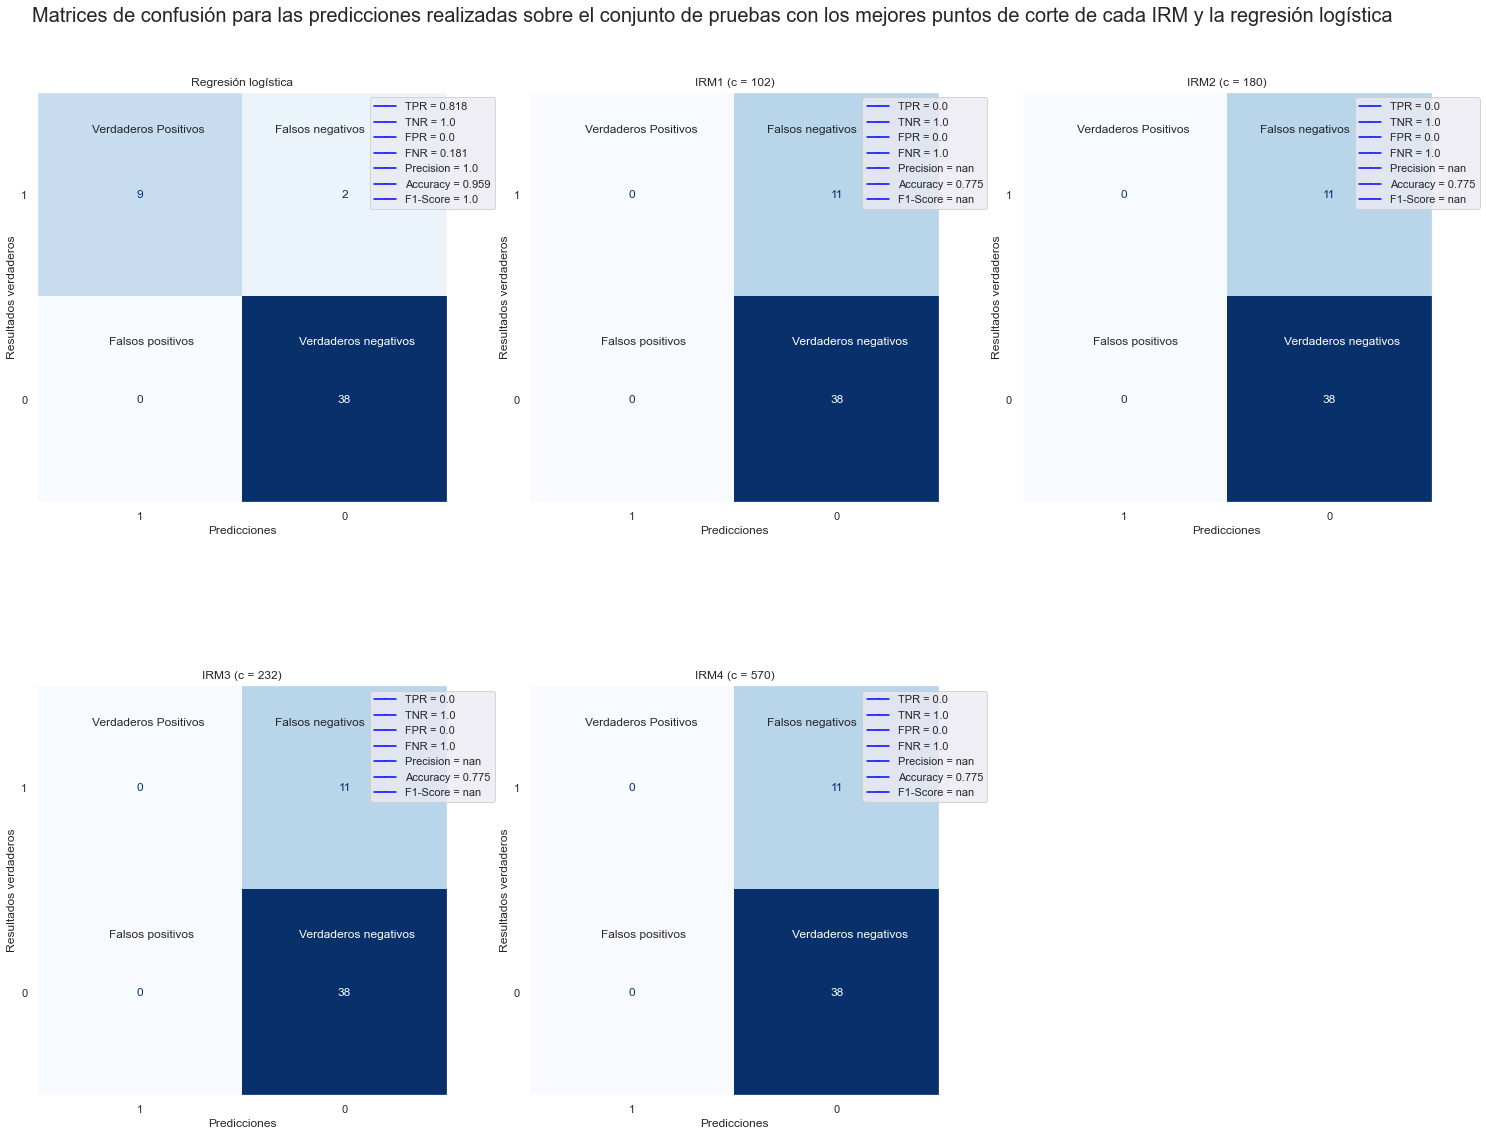

In [20]:
fig, axs = plt.subplots(2, 3, figsize=(25,20))
fig.delaxes(axs[1][2])

plt.suptitle('Matrices de confusión para las predicciones realizadas sobre el conjunto de pruebas con los mejores puntos de corte de cada IRM y la regresión logística', y=.91, fontsize=20)

predicciones_lr = lr.predict(X_test)
graficarMatrizConfusion(y_test, predicciones_lr, 'Regresión logística', axs[0][0])

for irm, ax in zip(puntos_corte.keys(), axs.ravel()[1:]):
    predicciones = np.where(X_test[irm] > puntos_corte[irm], 1, 0)
    graficarMatrizConfusion(y_test, predicciones, f'{irm} (c = {puntos_corte[irm]})', ax)
    
plt.show()

Algo curioso ha sucedido, los cuatro IRMs detectan como casos negativos al 100% de los ejemplos de prueba; como ya lo habíamos revisado, el desempeño de la regresión logística es casi perfecto.

## Conclusiones

La medición de la calidad de un algoritmo de clasificación binaria puede llegar a ser más complejo que el hecho de “no equivocarse”. Resultan de vital importancia entender la problemática y establecer desde un principo los criterios a satisfacer, pues en función de ello se deberá elegir la métrica de desempeño más adecuada.

La curva ROC nos ofrece una representación gráfica de la relación entre el la sensibilidad y la especificidad (1-especificidad), así como también un resumen de la habilidad para discriminar entre ambas clases mediente el área bajo la curva (AUC). Además, también puede ser utilizada para elegir el mejor punto de corte para el clasificador, por ejemplo, calculando el índice de Youden. En caso de que sea necesario analizar más a detalle otras métricas como Precision o Accuracy, la matriz de confusión resulta de gran ayuda para calcularlos y obtener una vista más general del desempeño del clasificador.

También es importante revisar las curvas de validación cuando se entrene un modelo de Machine learning para detectar casos de overfitting/underfitting.

Finalmente, en este artículo se ha propuesto un algoritmo de machine learning (regresión logística) que puede ser una herramienta auxiliar al momento de realizar diagnósticos de malignidad en tumores anexiales. Dicho clasificador obtuvo 95.9% de accuracy, 81.5% de sensibilidad y 100% de especificidad sobre el conjunto de datos de prueba.